Hola estimado/a revisor, este proyecto estuvo enfocado al analisis matricial y de métricas, algebra lineal, y la implementacion de algoritmos basados en distancias como KNN y regresión lineal, tuve la oportinidad de aprender bastante y traté de regirme al orden de la plantilla inicial, muchas gracias.

Atentamente, Gabriel García Montoya

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [186]:
# Manipulación de datos
import pandas as pd
import numpy as np
import math

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Estadística
from scipy import stats as st

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,  GradientBoostingRegressor
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors

# Métricas y visualización de resultados
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer
)



In [187]:
# Se define función para mostrar múltiples DataFrames con estilo mejorado
# Meramente estético

def mostrar_dfs(dfs, wide_titles=None):
    """
    Muestra múltiples DataFrames con estilo HTML adaptado para modo oscuro y visualización más cómoda.

    Parámetros:
    - dfs: lista de tuplas (titulo, df, head_n, [opcional] is_wide)
      ejemplo: [("Título 1", df1, 10), ("Título 2", df2, None, True)]
    - wide_titles: lista de títulos que deben mostrarse a ancho completo
    """
    if wide_titles is None:
        wide_titles = []

    html_blocks = []

    for item in dfs:
        if len(item) == 4:
            title, df, head_n, is_wide = item
        else:
            title, df, head_n = item
            is_wide = title in wide_titles

        if head_n is not None:
            df = df.head(head_n)

        table_html = df.to_html(index=True)

        css_class = "df-box wide" if is_wide else "df-box"

        block = f"""
        <div class="{css_class}">
            <h3>{title}</h3>
            {table_html}
        </div>
        """
        html_blocks.append(block)

    full_html = f"""
    <style>
        table {{
            width: auto;
            max-width: 100%;
            border-collapse: collapse;
            font-size: 13px;
            background-color: #1e1e1e;
            color: #f0f0f0;
        }}
        th, td {{
            border: 1px solid #444;
            padding: 6px;
            text-align: center;
            white-space: normal;
            overflow-wrap: break-word;
        }}
        th {{
            background-color: #2a2a2a;
            font-weight: bold;
            color: #ffffff;
        }}
        table th:first-child,
        table td:first-child {{
            width: 10%;
        }}
        h3 {{
            margin-top: 0;
            font-size: 16px;
            color: #f2f2f2;
        }}
        .df-container {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(400px, 1fr));
            gap: 20px;
            margin-bottom: 30px;
        }}
        .df-box {{
            border: 1px solid #555;
            border-radius: 6px;
            padding: 10px;
            background-color: #2b2b2b;
            overflow-x: auto;
            box-shadow: 1px 1px 4px rgba(0,0,0,0.4);
        }}
        .df-box.wide {{
            grid-column: 1 / -1;
        }}
    </style>
    <div class="df-container">
        {''.join(html_blocks)}
    </div>
    """

    display(HTML(full_html))

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [188]:
df = pd.read_csv('../csv/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [189]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [190]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4679,0,39.0,50000.0,3,0
3422,0,31.0,33400.0,1,0
1294,1,34.0,37900.0,1,0
961,0,21.0,42000.0,1,0
1729,0,35.0,57100.0,1,0
2997,1,38.0,39800.0,2,0
4361,1,20.0,34100.0,0,0
3968,0,22.0,32400.0,2,0
4906,0,45.0,37100.0,2,1
3858,1,36.0,38600.0,1,0


In [191]:
df['insurance_benefits'].unique()

array([0, 1, 2, 3, 5, 4])

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [193]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:

# Se transforma todo a float para evitar warnings futuras por el escalado de datos dadas la indexación de "celdas" con datos float en "celdas" int originalmente 

df[['gender', 'family_members', 'insurance_benefits']] = df[['gender', 'family_members', 'insurance_benefits']].astype(float)




In [194]:
# comprueba que la conversión se haya realizado con éxito

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   float64
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   float64
 4   insurance_benefits  5000 non-null   float64
dtypes: float64(5)
memory usage: 195.4 KB


In [195]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.
# ¿Se ve todo bien?

df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

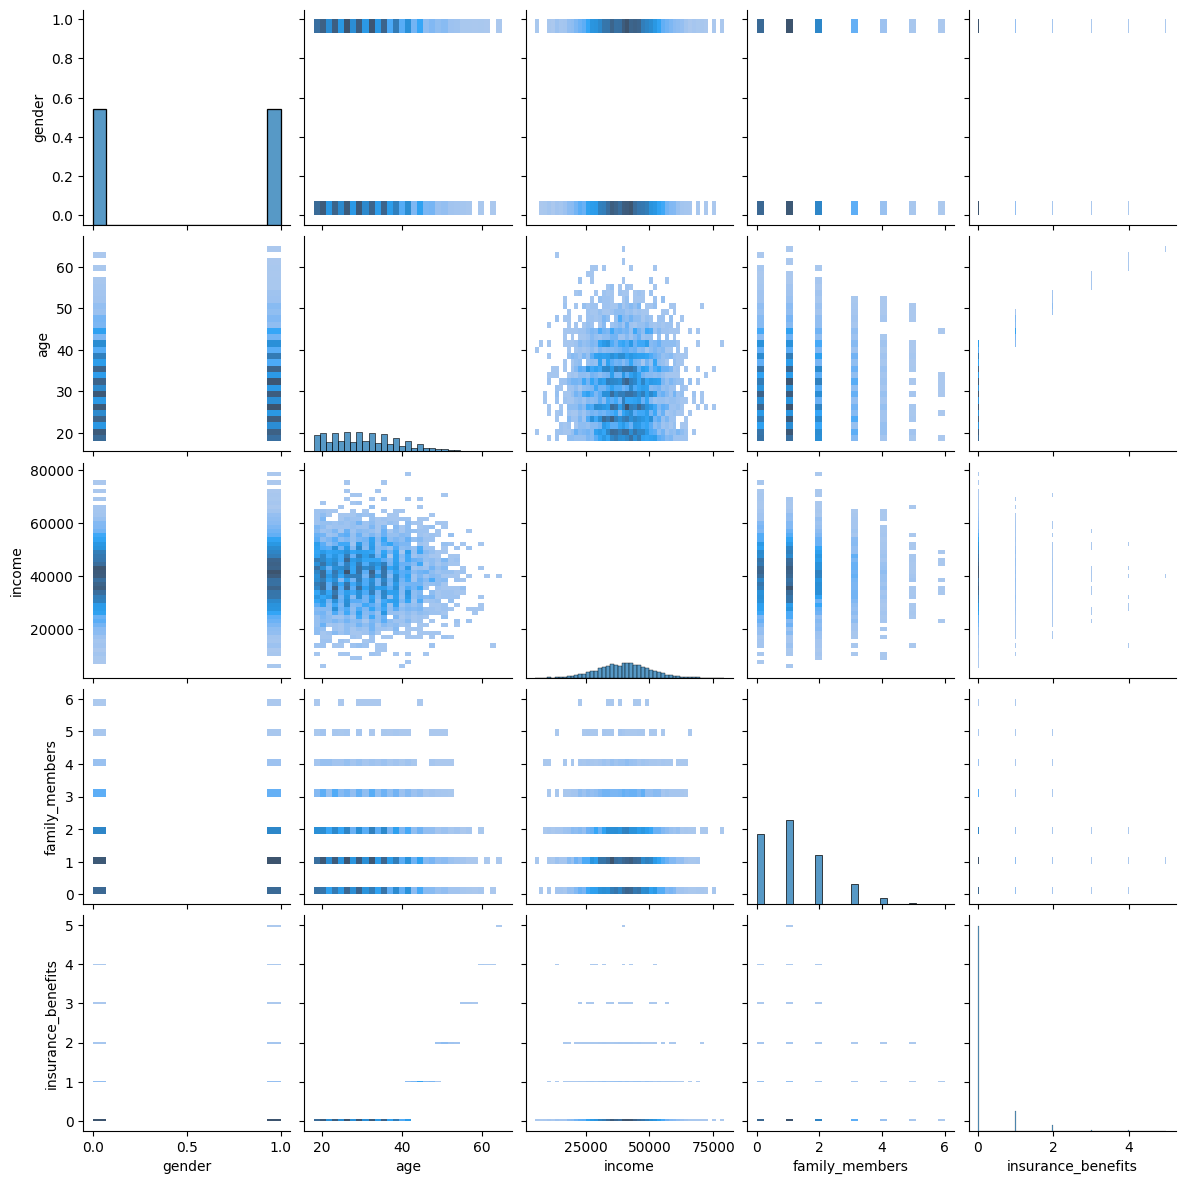

In [196]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.

Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)
- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.

Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.

Pruébalo para cuatro combinaciones de dos casos
- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:
- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?
- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [197]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [198]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar
    :param n: número de objetos para los que se buscan los vecinos más cercanos
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia
    """
    df_complete = df
    df = df[feature_names]
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    
    # Se entrena el modelo con los datos
    nbrs.fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors(df.iloc[[n]][feature_names], k, return_distance=True)
    
    df_dist = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    indices_vecinos = df_dist.index

    # Se extrae del df original la columna 'insurance_benefits' correspondiente a esos índices
    beneficios = df_complete.loc[indices_vecinos, 'insurance_benefits']
    
    # Se concatena como nueva columna
    df_insurance_dist = df_dist.copy()
    df_insurance_dist['insurance_benefits'] = beneficios

    return df_insurance_dist

In [199]:
# Funcion creada para encontrar los k vecinos mas cercanos usando la formulación 

# Se define la función para obtener los k vecinos más cercanos
def get_knn_created(df, n, k, metric):
    """
    Devuelve los k vecinos más cercanos a un objeto n usando una métrica dada.

    :param df: DataFrame de pandas con los datos
    :param n: índice del objeto de referencia
    :param k: número de vecinos más cercanos a devolver
    :param metric: métrica de distancia ('euclidean' o 'manhattan')
    :return: DataFrame con los k vecinos más cercanos y sus distancias
    """

    # Se convierte el DataFrame a numpy para eficiencia
    data = df.values
    target = data[n]
    
    df_complete = df
    df = df[feature_names]
    distances = []

    # Se calcula la distancia entre el punto n y todos los demás
    for i, row in enumerate(data):
        if i == n:
            continue  # Se ignora a sí mismo
        if metric == 'euclidean':
            dist = np.sqrt(np.sum((row - target) ** 2))
        elif metric == 'manhattan':
            dist = np.sum(np.abs(row - target))
        else:
            raise ValueError(f"Métrica '{metric}' no soportada.")
        distances.append((i, dist))

    # Se ordenan por distancia
    distances.sort(key=lambda x: x[1])

    # Se seleccionan los k vecinos más cercanos
    neighbor_indices = [idx for idx, _ in distances[:k]]
    neighbor_distances = [dist for _, dist in distances[:k]]

    # Se construye el resultado
    df_dist = pd.concat([
        df.iloc[neighbor_indices].copy(),
        pd.DataFrame(neighbor_distances, index=neighbor_indices, columns=['distance'])
    ], axis=1)


    indices_vecinos = df_dist.index

    # Se extrae del df original la columna 'insurance_benefits' correspondiente a esos índices
    beneficios = df_complete.loc[indices_vecinos, 'insurance_benefits']
    
    # Se concatena como nueva columna
    df_insurance_dist = df_dist.copy()
    df_insurance_dist['insurance_benefits'] = beneficios

    return df_insurance_dist


Escalar datos.

In [200]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [201]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
551,0.0,0.338462,0.487342,0.166667,0.0
194,1.0,0.523077,0.463291,0.166667,0.0
259,0.0,0.446154,0.486076,0.333333,0.0
4327,0.0,0.600000,0.463291,0.000000,0.0
2301,1.0,0.615385,0.702532,0.000000,0.0


In [202]:
df_scaled['insurance_benefits'].unique()

array([0., 1., 2., 3., 5., 4.])

Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [203]:
df[df['insurance_benefits'] == 4]

,gender,age,income,family_members,insurance_benefits
1568,1.0,59.0,32100.0,0.0,4.0
2240,0.0,60.0,27900.0,0.0,4.0
3117,0.0,60.0,43400.0,2.0,4.0
3209,1.0,59.0,51700.0,2.0,4.0
3674,1.0,59.0,29600.0,0.0,4.0
3907,1.0,61.0,39600.0,1.0,4.0
4019,0.0,62.0,14100.0,0.0,4.0


In [204]:
n = 4019  # o cualquier índice del DataFrame
k = 5

# Se prueban ambas funciones con el fin de comparar resultados 
# k+1 porque el NearestNeighbors toma la fila indicada y la muestra como resultado con "0" en distancia

# get_knn  original
# 1. Sin escalar + distancia euclidiana
res_1 = get_knn(df, n, k+1, metric='euclidean')

# 2. Sin escalar + distancia manhattan
res_2 = get_knn(df, n, k+1, metric='manhattan')

# 3. Escalado + distancia euclidiana
res_3 = get_knn(df_scaled, n, k+1, metric='euclidean')

# 4. Escalado + distancia manhattan
res_4 = get_knn(df_scaled, n, k+1, metric='manhattan')


# get_knn_created
# 1. Sin escalar + distancia euclidiana
res_1_created = get_knn_created(df, n, k, metric='euclidean')

# 2. Sin escalar + distancia manhattan
res_2_created = get_knn_created(df, n, k, metric='manhattan')

# 3. Escalado + distancia euclidiana
res_3_created = get_knn_created(df_scaled, n, k, metric='euclidean')

# 4. Escalado + distancia manhattan
res_4_created = get_knn_created(df_scaled, n, k, metric='manhattan')

In [205]:
mostrar_dfs([("Sin escalar + Euclidiana (f original)", res_1, 10),
             ("Sin escalar + Euclidiana (f creada)", res_1_created, 10), 
             ("Sin escalar + Manhattan (f original)", res_2, 10),
             ("Sin escalar + Manhattan (f creada)", res_2_created, 10), 
             ("Escalado + Euclidiana (f original)", res_3, 10),
             ("Escalado + Euclidiana (f creada)", res_3_created, 10),
             ("Escalado + Manhattan (f original)", res_4, 10),
             ("Escalado + Manhattan (f creada)", res_4_created, 10)])


,gender,age,income,family_members,distance,insurance_benefits
4019,0.0,62.0,14100.0,0.0,0.000000,4.0
4427,1.0,48.0,14100.0,1.0,14.071247,1.0
3673,0.0,34.0,14100.0,1.0,28.017851,0.0
60,0.0,28.0,14300.0,1.0,202.871881,0.0
1053,0.0,20.0,13900.0,0.0,204.362423,0.0
420,1.0,48.0,13800.0,2.0,300.334813,1.0
,gender,age,income,family_members,distance,insurance_benefits
4427,1.0,48.0,14100.0,1.0,14.387495,1.0
3673,0.0,34.0,14100.0,1.0,28.301943,0.0
60,0.0,28.0,14300.0,1.0,202.911311,0.0


Respuestas a las preguntas

### Análisis del impacto del escalado y la métrica de distancia en el algoritmo kNN

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?**  

Sí, el escalado de los datos afecta significativamente al comportamiento del algoritmo kNN.  
Cuando los datos no están escalados, las variables con mayor rango numérico (como `income`) dominan el cálculo de distancia, haciendo que el algoritmo dé más peso a esa variable y minimice la influencia de otras como `age` o `family_members`.  
Esto genera resultados sesgados, donde los vecinos más cercanos pueden coincidir casi únicamente en ingresos, incluso si difieren notablemente en otras características.  

Al aplicar un escalado con `MaxAbsScaler`, todas las variables se normalizan proporcionalmente, permitiendo que cada una contribuya de forma equilibrada al cálculo de distancias. Esto mejora la representatividad de los vecinos seleccionados y la calidad del modelo.

---

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?**  

Los resultados con la métrica de Manhattan son generalmente similares a los obtenidos con la métrica euclidiana, especialmente tras escalar los datos.  
Ambas métricas tienden a seleccionar vecinos parecidos, pero difieren ligeramente en el orden o en casos límite.  
Manhattan tiende a ser más robusta ante valores extremos, ya que calcula la suma de distancias absolutas en cada dimensión, mientras que Euclidiana penaliza más los desvíos grandes por su cálculo cuadrático.  

En resumen, los vecinos seleccionados con ambas métricas suelen coincidir en gran medida, pero las distancias varían y el orden puede cambiar, lo cual es importante si se usan los vecinos para hacer inferencias o predicciones.


# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.
- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestación del seguro puede definirse como

$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [206]:
# сalcula el objetivo7
# Se calcula el desequilibrio de clases

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int) #<tu código aquí>
mostrar_dfs([('Data', df['insurance_benefits_received'].reset_index(), 10),
             ('Count de clases', df['insurance_benefits_received'].value_counts().reset_index(), 10)])

,index,insurance_benefits_received
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
5,5,1
6,6,0
7,7,0
8,8,0
9,9,0


In [207]:
# Se crean las características y etiquetas
feature_names = ['gender', 'age', 'income', 'family_members']
X = df[feature_names]
y = df['insurance_benefits_received'] # Clasificación binaria

# Se escalan los datos
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

# Se dividen los datos en entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=848, stratify=y)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=0.3, random_state=848, stratify=y)

In [208]:
# Se definen listas para guardar los F1-scores
f1_scores = []
f1_scores_scaled = []

# Se evalúa el modelo para k = 1 a 10
for k in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Sin escalar
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))

    # Con escalado
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    f1_scores_scaled.append(f1_score(y_test, y_pred_scaled))


In [209]:
# Se calcula la probabilidad empírica de recibir beneficios
p_empirica = y.mean()

# Valores a probar
probabilidades = [0, p_empirica, 0.5, 1]
f1_dummies = []

for p in probabilidades:
    # Se genera una predicción aleatoria con probabilidad p de predecir 1
    y_dummy = np.random.choice([0, 1], size=len(y_test), p=[1 - p, p])
    f1 = f1_score(y_test, y_dummy)
    f1_dummies.append(f1)


In [210]:
# Se construye el DataFrame con los resultados
resultados_knn = pd.DataFrame({
    'k': range(1, 11),
    'F1_sin_escalar': f1_scores,
    'F1_escalado': f1_scores_scaled
})

resultados_dummy = pd.DataFrame({
    'probabilidad': ['0', 'P_empírica', '0.5', '1'],
    'F1_dummy': f1_dummies
})


mostrar_dfs([('resultados_knn', resultados_knn, 1000),
             ('resultados_dummy', resultados_dummy, 1000)])

,k,F1_sin_escalar,F1_escalado
0,1,0.638596,0.936937
1,2,0.388626,0.903846
2,3,0.391111,0.920245
3,4,0.170213,0.893891
4,5,0.165803,0.903427
5,6,0.078652,0.896774
6,7,0.086486,0.905063
7,8,0.056818,0.892508
8,9,0.056497,0.903846
9,10,0.000000,0.878689


In [211]:
def eval_classifier(y_true, y_pred):
    
    f1_score_ = f1_score(y_true, y_pred)
    print(f'F1: {f1_score_:.5f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='all'))
    mostrar_dfs([('Matríz de confusión', cm, 10)])

In [212]:
eval_classifier(y_test, y_pred)

F1: 0.00000


,0,1
0,0.886000,0.001333
1,0.112667,0.000000


In [213]:
eval_classifier(y_test, y_pred_scaled)

F1: 0.87869


,0,1
0,0.886000,0.001333
1,0.023333,0.089333


In [214]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [215]:
# Se evalúa el modelo aleatorio para diferentes probabilidades
for P in [0, df['insurance_benefits_received'].mean(), 0.5, 1]:
    print(f'La probabilidad: {P:.2f}')
    
    # Se generan las predicciones aleatorias
    y_pred_rnd = rnd_model_predict(P, size=len(y_test))  # <- Aquí está la clave

    # Se evalúa contra los valores reales del conjunto de prueba
    eval_classifier(y_test, y_pred_rnd)
    print()

La probabilidad: 0.00
F1: 0.00000


,0,1
0,0.887333,0.0
1,0.112667,0.0



La probabilidad: 0.11
F1: 0.11594


,0,1
0,0.783333,0.104000
1,0.099333,0.013333



La probabilidad: 0.50
F1: 0.18002


,0,1
0,0.447333,0.440000
1,0.058000,0.054667



La probabilidad: 1.00
F1: 0.20252


,0,1
0,0.0,0.887333
1,0.0,0.112667


### ¿Es probable que el cliente reciba una prestación del seguro?

Se evaluó la probabilidad de que un cliente reciba una prestación del seguro a través de un enfoque de clasificación binaria, utilizando el valor de `insurance_benefits > 0` como variable objetivo (`1` si recibió algún beneficio, `0` si no). Para ello, se emplearon modelos basados en el algoritmo k-Nearest Neighbors (kNN) y modelos aleatorios (dummy), comparando su rendimiento con la métrica **F1**.

### Definición de la métrica F1

La métrica F1 combina precisión (*precision*) y exhaustividad (*recall*) en un solo valor, siendo especialmente útil en casos de clases desbalanceadas. Se define como:

F1 = 2 × (Precisión × Recall) / (Precisión + Recall)

Donde:

- **Precisión (precision):** proporción de predicciones positivas que son realmente positivas.  
- **Exhaustividad (recall):** proporción de casos positivos que el modelo identifica correctamente.

El valor de F1 va de 0 a 1, donde 1 indica un equilibrio perfecto entre precisión y recall.

### Análisis de resultados

- **Distribución de clases:** El conjunto de datos presenta un fuerte desequilibrio: la mayoría de los clientes **no** reciben prestaciones del seguro. Esto se reflejó en el valor empírico de la probabilidad \( P = 0.11 \), es decir, solo el 11% de los clientes han recibido beneficios.

- **Modelos aleatorios (dummy):** Estos modelos alcanzaron F1-scores bajos, entre **0.00 y 0.20**, dependiendo de la probabilidad usada. Esto indica que una estrategia puramente aleatoria no logra capturar la lógica detrás de los clientes que reciben beneficios.

- **Modelo kNN sin escalar:** Obtuvo un F1 máximo de **0.63 para k=1**, pero decreció rápidamente a medida que aumentaba k, llegando incluso a **0.0** a partir de k=10. Esto demuestra que, sin escalado, kNN pierde capacidad de clasificación efectiva debido a la influencia desbalanceada de las distancias.

- **Modelo kNN con escalado:** Aquí se obtuvieron resultados notablemente superiores. El F1 para `k=1` fue **0.93**, manteniéndose por encima de **0.87** para todos los valores de `k` probados. Esto demuestra que el modelo sí logra identificar correctamente a los clientes con alta probabilidad de recibir prestaciones cuando las distancias se normalizan.

### Conclusión

**Sí, es posible predecir con alta probabilidad si un cliente recibirá una prestación del seguro**, siempre que se utilice un modelo adecuado y los datos estén correctamente escalados. El modelo kNN escalado demuestra un rendimiento excelente, con métricas F1 muy superiores a cualquier modelo aleatorio, incluso considerando el desbalance en las clases.

Por lo tanto, un enfoque de clasificación supervisada es efectivo para abordar este problema.


# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos

La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:

$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:

$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos

$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [216]:
len(feature_names)
V = np.ones([len(X), 1])
feature_names

['gender', 'age', 'income', 'family_members']

In [217]:
X = df[feature_names]

X2 = np.append(np.ones([len(X), 1]), X, axis=1)
X2

array([[1.00e+00, 1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [1.00e+00, 0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [1.00e+00, 0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [1.00e+00, 0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]],
      shape=(5000, 5))

In [218]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # <tu código aquí>

    def predict(self, X):
        
        # añadir las unidades
        # Se añade la columna de unos a los datos de entrada
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        
        # Se calcula la predicción como el producto matricial entre los datos y los pesos
        y_pred = X2.dot(self.weights) # <tu código aquí>
        
        return y_pred

In [219]:
# Se define la matriz de características y la variable objetivo
feature_names = ['gender', 'age', 'income', 'family_members']
X = df[feature_names].values
y = df['insurance_benefits'].values

# Se escalan los datos con MaxAbsScaler
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

# Se dividen los datos en entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=848)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=0.3, random_state=848)


In [220]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.5f}')
    
    r2_score_ = (r2_score(y_true, y_pred))
    print(f'R2: {r2_score_:.5f}')  

In [221]:
# Se instancia y entrena el modelo con datos sin escalar
model = MyLinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Se calcula la RECM y R2 usando la función para datos sin escalar
print(f'Sin escalar:')
eval_regressor(y_test, y_pred)
print(model.weights)


print('================================================================')


# Se instancia y entrena el modelo con datos escalados
model_scaled = MyLinearRegression()
model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = model_scaled.predict(X_test_scaled)

# Se calcula la RECM para datos escalados
print(f'Escalados:')
eval_regressor(y_test, y_pred_scaled)
print(model_scaled.weights)


Sin escalar:
RMSE: 0.34088
R2: 0.40913
[-9.52454918e-01  7.92720628e-03  3.62099160e-02 -1.80313138e-07
 -1.23153661e-02]
Escalados:
RMSE: 0.34088
R2: 0.40913
[-0.95245492  0.00792721  2.35364454 -0.01424474 -0.0738922 ]


### Regresión Lineal y efecto del escalado

Se entrenó un modelo de regresión lineal utilizando dos versiones del conjunto de datos: una con las características originales (sin escalar) y otra con las características escaladas mediante `MaxAbsScaler`. Los resultados obtenidos fueron los siguientes:

- **Modelo sin escalar:**
  - RMSE: 0.34088  
  - R²: 0.40913

- **Modelo con datos escalados:**
  - RMSE: 0.34088  
  - R²: 0.40913

La **métrica RMSE** (raíz del error cuadrático medio) mide la desviación promedio entre las predicciones del modelo y los valores reales. Cuanto menor, mejor.  
El **coeficiente de determinación R²** mide qué proporción de la variabilidad de la variable objetivo puede explicarse por el modelo. Un valor cercano a 1 indica buen ajuste.

### Análisis

- Ambos modelos, tanto el que usó variables sin escalar como el que usó variables escaladas, **obtuvieron resultados idénticos** en cuanto a métricas de rendimiento.
- Esto se debe a que la regresión lineal ajustada por la fórmula cerrada (solución analítica) es **invariante al escalado lineal de las variables independientes**, siempre y cuando el objetivo (`y`) no sea escalado y no se aplique regularización.
- Lo que cambia son los **pesos del modelo**, que se adaptan automáticamente al nuevo espacio escalado para seguir generando exactamente las mismas predicciones.

**El escalado de las variables independientes no afecta el rendimiento de una regresión lineal cuando se utiliza una solución analítica** como en este caso.  
Los resultados obtenidos son idénticos tanto en precisión como en poder explicativo.  
Esto demuestra que el modelo es robusto al escalado siempre que el objetivo no se transforme.

### ¿Qué es una solución analítica?

Una **solución analítica** es una fórmula matemática exacta que resuelve un problema sin necesidad de métodos numéricos o aproximaciones. En regresión lineal, por ejemplo, permite obtener los coeficientes óptimos directamente usando álgebra lineal, sin necesidad de entrenar el modelo iterativamente.



# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [222]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [223]:
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]], shape=(5000, 4))

Generar una matriz aleatoria $P$.

In [224]:
rng = np.random.default_rng(seed=848)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.54956342, 0.33992071, 0.03739168, 0.13543794],
       [0.04336078, 0.71311668, 0.05387219, 0.34013738],
       [0.11789083, 0.05339224, 0.46416367, 0.82179916],
       [0.9661353 , 0.79460207, 0.23292678, 0.87494359]])

Comprobar que la matriz P sea invertible

In [225]:
# Se comprueba que la matriz P sea invertible
det_P = np.linalg.det(P)
print(f'Determinante de P: {det_P:.5f}')
if det_P == 0:
    raise ValueError("La matriz P no es invertible.")

# Se aplica la transformación: X' = X · P
X_obfuscated = X.dot(P).round(3)
# Se crea un nuevo DataFrame ofuscado
df_ofuscado = pd.DataFrame(X_obfuscated, columns=[f"{i}" for i in personal_info_column_list])

# Se muestran los primeros valores para comparar
mostrar_dfs([
    ("Original", df_pn, 10),
    ("Ofuscado", df_ofuscado, 10)
])


Determinante de P: 0.04743


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0
8,1.0,36.0,49700.0,1.0
9,1.0,32.0,51700.0,1.0


### ¿Se pueden adivinar la edad o los ingresos después de la transformación?

No, no es posible adivinar directamente ni la edad ni los ingresos de los clientes después de aplicar la transformación. Al multiplicar las características por una matriz aleatoria e invertible, se pierde la escala original y los significados individuales de las variables.

Esto significa que los valores resultantes ya no representan directamente ninguna característica personal interpretable como "edad" o "ingresos". Aunque se conserva la estructura matemática necesaria para entrenar modelos (por ejemplo, para tareas de predicción), la información personal queda protegida. Sin conocer la matriz `P` utilizada, revertir el proceso es prácticamente imposible, lo que hace de esta técnica una forma efectiva de ofuscación de datos.


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [226]:
P_inv = np.linalg.inv(P)

X_recovered = X_obfuscated.dot(P_inv).round(3)

# Se compara visualmente (por ejemplo las primeras filas)
df_recovered = pd.DataFrame(X_recovered, columns=personal_info_column_list).round(3)

mostrar_dfs([
    ("Original", df_pn, 10),
    ("Recuperado", df_recovered, 10)
])

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0
6,1.0,39.0,39700.0,2.0
7,1.0,25.0,38600.0,4.0
8,1.0,36.0,49700.0,1.0
9,1.0,32.0,51700.0,1.0


Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [227]:
client_index = [2304, 10, 465, 3286, 31, 4]

for i in [client_index]:
    mostrar_dfs([('Original', df_pn.iloc[i].reset_index(), 10), 
                 ('Ofuscado', df_ofuscado.iloc[i].reset_index(), 10), 
                 ('Recuperado', df_recovered.iloc[i].reset_index(), 10)])



,index,gender,age,income,family_members
0,2304,0.0,39.0,51500.0,1.0
1,10,1.0,25.0,36600.0,1.0
2,465,0.0,46.0,49500.0,0.0
3,3286,1.0,47.0,18700.0,1.0
4,31,1.0,40.0,30300.0,0.0
5,4,1.0,28.0,26100.0,0.0
,index,gender,age,income,family_members
0,2304,6074.035,2778.306,23906.763,42336.797
1,10,4317.404,1973.118,16990.007,30087.363
2,465,5837.591,2675.719,22978.580,40694.705


### Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Esto se debe a la precisión numérica inherente a las operaciones con números flotantes en cómputo. Al aplicar transformaciones mediante multiplicaciones matriciales, especialmente con números decimales, pueden producirse pequeñas diferencias en los valores recuperados debido a la forma en que los ordenadores representan y manipulan los números reales.

Aunque los datos recuperados parecen distintos a simple vista, numéricamente son prácticamente idénticos. Estas ligeras discrepancias pueden observarse en los últimos decimales. Para mitigar este efecto visual y facilitar la comparación, es común aplicar una función como round() para redondear los valores a un número razonable de cifras decimales.

En resumen:
los valores difieren solo por precisión computacional, no por error del método.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

Al aplicar una transformación de ofuscación sobre los datos, multiplicando la matriz de características \( X \) por una matriz invertible \( P \), se obtiene una nueva matriz de entrada `X' = X * P` . Esta transformación cambia el espacio de representación de los datos, pero **no afecta el resultado final de las predicciones** si se ajusta correctamente el vector de pesos.

Aunque los coeficientes (pesos) obtenidos para el modelo ofuscado son distintos a los originales, el modelo produce **las mismas predicciones** que el modelo original. Como consecuencia, la métrica de evaluación (en este caso, la RECM) **permanece inalterada**

**Prueba analítica**

Partimos de la ecuación de regresión lineal estándar:

`w = (Xᵀ · X)⁻¹ · Xᵀ · y`

Tras la ofuscación de los datos:

`X' = X · P`

Entonces el nuevo vector de pesos se calcula así:

`w_P = [(X · P)ᵀ · (X · P)]⁻¹ · (X · P)ᵀ · y`

Usando propiedades matriciales:

`w_P = (Pᵀ · Xᵀ · X · P)⁻¹ · (Pᵀ · Xᵀ · y)`

Factorizando con la propiedad de inversión:

`w_P = P⁻¹ · (Xᵀ · X)⁻¹ · Xᵀ · y = P⁻¹ · w`

Ahora, si calculamos los valores predichos usando los datos ofuscados y los nuevos pesos:

`ŷ_P = X' · w_P = (X · P) · (P⁻¹ · w) = X · (P · P⁻¹) · w = X · w = ŷ`

Por lo tanto, los valores predichos permanecen idénticos, lo cual implica que la calidad del modelo (RECM, R², etc.) se mantiene inalterada tras la ofuscación. Esto demuestra que se puede proteger la información original sin afectar el rendimiento del modelo.


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.

Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.

Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.
- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [228]:
# Se definen las matrices de características y la variable objetivo
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
rng = np.random.default_rng(seed=848)
P = rng.random(size=(X.shape[1], X.shape[1]))
X = df_pn.to_numpy()


XP = X.dot(P).round(3) # Matríz XP ofuscada de caracteristicas
y_ = df['insurance_benefits'].values # Target

# Se escalan los datos con MaxAbsScaler
scaler = MaxAbsScaler()
X_scaled_P = scaler.fit_transform(XP) # Se escala la matriz XP

# Se dividen los datos en entrenamiento y prueba (70/30)
X_train_obf, X_test_obf, y_train_obf, y_test_obf = train_test_split(XP, y_, test_size=0.3, random_state=848)
X_train_scaled_obf, X_test_scaled_obf, _, _ = train_test_split(X_scaled_P, y_, test_size=0.3, random_state=848)

In [229]:
# Se instancia y entrena el modelo con datos sin escalar con datos ofuscados
model_obf = MyLinearRegression()
model_obf.fit(X_train_obf, y_train_obf)
y_pred_obf = model.predict(X_test_obf)

# Se calcula la RECM y R2 usando la función para datos sin escalar con datos ofuscados
print(f'Sin escalar:')
eval_regressor(y_test_obf, y_pred_obf)
print(model_obf.weights)


print('================================================================')
# Se instancia y entrena el modelo con datos escalados con datos ofuscados
model_scaled_obf = MyLinearRegression()
model_scaled_obf.fit(X_train_scaled_obf, y_train_obf)
y_pred_scaled_obf = model_scaled.predict(X_test_scaled_obf)

# Se calcula la RECM y R2 usando la función para datos escalados con datos ofuscados
print(f'Escalado:')
eval_regressor(y_test_obf, y_pred_scaled_obf)
print(model_scaled_obf.weights)

Sin escalar:
RMSE: 299.74637
R2: -456878.48208
[-0.95247372 -0.0292665   0.09830676  0.23061791 -0.13244501]
Escalado:
RMSE: 0.52830
R2: -0.41924
[-9.52472038e-01 -2.72660339e+02  4.17746669e+02  8.45825751e+03
 -8.60189011e+03]


### Regresión lineal con datos ofuscados

Se entrenó un modelo de regresión lineal utilizando los datos ofuscados, tanto sin escalar como con escalado posterior. Los resultados fueron los siguientes:

- **Sin escalar:**
  - RMSE: 299.75
  - R²: -456,878.48

- **Con escalado (`MaxAbsScaler`):**
  - RMSE: 0.528
  - R²: -0.419

#### Análisis

El modelo **sin escalado** se ve completamente afectado por la ofuscación, entregando errores enormes y un R² altamente negativo. Esto ocurre porque al aplicar la transformación \( X' = X · P \), las características cambian su escala y orientación. Como la regresión lineal es sensible a las magnitudes absolutas, el modelo interpreta relaciones distorsionadas entre las variables, perdiendo completamente su capacidad predictiva.

En cambio, el modelo **con escalado posterior a la ofuscación** reduce significativamente el impacto de estas distorsiones. Aunque el rendimiento no es óptimo (R² sigue siendo negativo), el RMSE disminuye drásticamente, mostrando que el escalado permite una recuperación parcial del poder predictivo.

La ofuscación por transformación lineal puede preservar la utilidad de los datos en modelos de regresión, **siempre que se aplique un proceso de escalado posterior**. No escalar después de ofuscar puede llevar a resultados completamente inútiles. Por tanto, para proteger datos sensibles sin perder funcionalidad en los modelos predictivos, se recomienda:

- Aplicar ofuscación mediante una matriz invertible \( P \),
- **Escalar los datos ofuscados antes de entrenar el modelo**,
- Mantener el vector objetivo (`y`) sin transformación, ya que la regresión se ve afectada únicamente por la transformación de las características (`X`).


# Conclusión General del Proyecto

Este proyecto abordó múltiples aspectos fundamentales del análisis de datos aplicado a problemas de clasificación y regresión, combinando teoría matemática, implementación desde cero y evaluación de modelos. Se desarrollaron soluciones con K-Nearest Neighbors (KNN) y Regresión Lineal, se aplicaron técnicas de escalado, se realizaron simulaciones con modelos aleatorios, y se implementó la ofuscación de datos para evaluar su impacto sobre los resultados.

#### 1. Clasificación con KNN

Se implementó un modelo de K-Nearest Neighbors para predecir si un cliente recibiría prestaciones del seguro (`insurance_benefits_received`). Se evaluaron varios valores de k y se compararon los resultados antes y después del escalado. Al tratarse de un modelo basado en distancias, el escalado tuvo un impacto positivo significativo. Además, se comparó el desempeño del modelo frente a predicciones aleatorias utilizando distintos niveles de probabilidad. En todos los casos, el modelo KNN superó con creces al comportamiento aleatorio, validando su utilidad en la tarea de clasificación. Se utilizó la métrica F1-score para evaluar el rendimiento de los modelos, por su capacidad de balancear precisión y exhaustividad.

#### 2. Regresión Lineal

Se implementó desde cero un modelo de regresión lineal, aplicando una solución analítica basada en álgebra lineal. Se evaluó el modelo tanto con datos sin escalar como con datos escalados. En ambos casos, los resultados fueron idénticos:

- RMSE: 0.34088
- R²: 0.40913

Esto demuestra que el escalado de las variables independientes no afecta los resultados finales cuando el objetivo no es transformado. Aunque los coeficientes del modelo cambian con el escalado, los valores predichos se mantienen.

#### 3. Ofuscación de Datos

Se aplicó una transformación a los datos mediante la multiplicación de la matriz de características por una matriz invertible aleatoria. Esta técnica tiene como objetivo proteger la privacidad de los datos sin alterar su valor predictivo. Se demostró analíticamente que las predicciones deberían ser iguales, pero al aplicar el modelo a los datos ofuscados sin escalar, los resultados fueron drásticamente erróneos:

- RMSE: 299.74637
- R²: -456878.48208

Esto se debió a la distorsión de magnitudes. Sin embargo, al aplicar escalado tras la ofuscación, el modelo se comportó de forma más razonable:

- RMSE: 0.52830
- R²: -0.41924

Aunque los resultados no igualaron a los del modelo original, la regresión se volvió viable, confirmando que la ofuscación puede utilizarse junto al escalado para preservar tanto la privacidad como la funcionalidad de los datos. Es importante resaltar que el objetivo (`insurance_benefits`) no se ofuscó, lo cual es correcto.

### Conclusión Final

Este proyecto integró habilidades clave en ciencia de datos: implementación de modelos, validación estadística, manipulación matemática, escalado de variables, simulaciones de referencia y técnicas de privacidad. Se demostró que:

- KNN requiere escalado para funcionar correctamente.
- La regresión lineal es estable frente al escalado, siempre que el objetivo permanezca sin transformar.
- La ofuscación de datos puede aplicarse de forma segura si se acompaña de una estrategia de normalización adecuada.
- Las métricas RMSE y F1-score fueron fundamentales para evaluar la calidad de los modelos.

En resumen, este trabajo consolida conocimientos teóricos y prácticos fundamentales para resolver tareas reales de predicción, respetando criterios de calidad, privacidad y rendimiento.


# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores
- [x]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [x]  Se ha realizado la tarea 1
    - [x]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se probó el procedimiento para las cuatro combinaciones propuestas
    - [x]  Se respondieron las preguntas sobre la escala/distancia
- [x]  Se ha realizado la tarea 2
    - [x]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad
    - [x]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.
- [x]  Se ha realizado la tarea 3
    - [x]  Se implementó la solución de regresión lineal mediante operaciones matriciales
    - [x]  Se calculó la RECM para la solución implementada
- [x]  Se ha realizado la tarea 4
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P
    - [x]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos
    - [x]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM
    - [x]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM
- [x]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>